# Schema ERD Reference

This notebook materializes entity-relationship diagrams (ERDs) for the DuckDB analytics workspace. Run the cells in order to generate diagrams for the staging, dimensional/fact, and mart layers.


## Setup

Install Graphviz once per environment before rendering the diagrams.


In [1]:
%pip install graphviz --quiet


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Helpers

Load DuckDB and create an ERD renderer.


In [2]:
import duckdb
from graphviz import Digraph
from IPython.display import display

con = duckdb.connect("dev.db")


def get_columns(table_name):
    try:
        df = con.execute(f"PRAGMA table_info('{table_name}')").fetchdf()
    except Exception as exc:
        print(f"Warning: could not inspect {table_name}: {exc}")
        return []
    return [f"{row['name']} ({row['type']})" for _, row in df.iterrows()]


def render_er(name, tables, relationships=None, filename=None):
    graph = Digraph(name=name, format="svg")
    graph.attr(rankdir="LR", fontname="Helvetica")
    graph.attr("node", shape="record", fontname="Helvetica", fontsize="10")

    for table in tables:
        columns = get_columns(table)
        if not columns:
            label = f"{{{table}|(table not found)}}"
        else:
            col_text = "\l".join(columns) + "\l"
            label = f"{{{table}|{col_text}}}"
        graph.node(table, label=label)

    relationships = relationships or []
    for source, target, label in relationships:
        graph.edge(source, target, label=label, fontname="Helvetica", fontsize="9")

    path = filename or f"{name}.svg"
    graph.render(filename=path, cleanup=True)
    display(graph)

## Staging Layer ERD


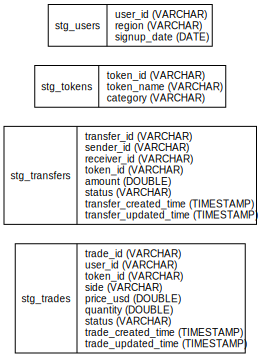

In [3]:
staging_tables = ["stg_trades", "stg_transfers", "stg_tokens", "stg_users"]
staging_relationships = []
render_er(
    "staging_layer",
    staging_tables,
    staging_relationships,
    filename="notebook/dev/exports/staging_layer",
)

## Dimensional & Fact Layer ERD


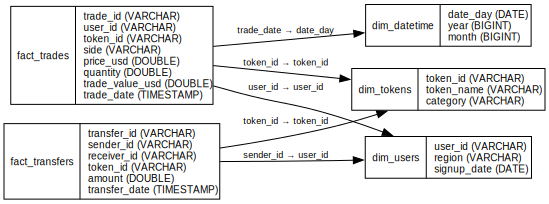

In [4]:
dim_fact_tables = [
    "dim_users",
    "dim_tokens",
    "dim_datetime",
    "fact_trades",
    "fact_transfers",
]
dim_fact_relationships = [
    ("fact_trades", "dim_users", "user_id → user_id"),
    ("fact_trades", "dim_tokens", "token_id → token_id"),
    ("fact_trades", "dim_datetime", "trade_date → date_day"),
    ("fact_transfers", "dim_users", "sender_id → user_id"),
    ("fact_transfers", "dim_tokens", "token_id → token_id"),
]
render_er(
    "dim_fact_layer",
    dim_fact_tables,
    dim_fact_relationships,
    filename="notebook/dev/exports/dim_fact_layer",
)

## Mart & Data-Quality Layer ERD


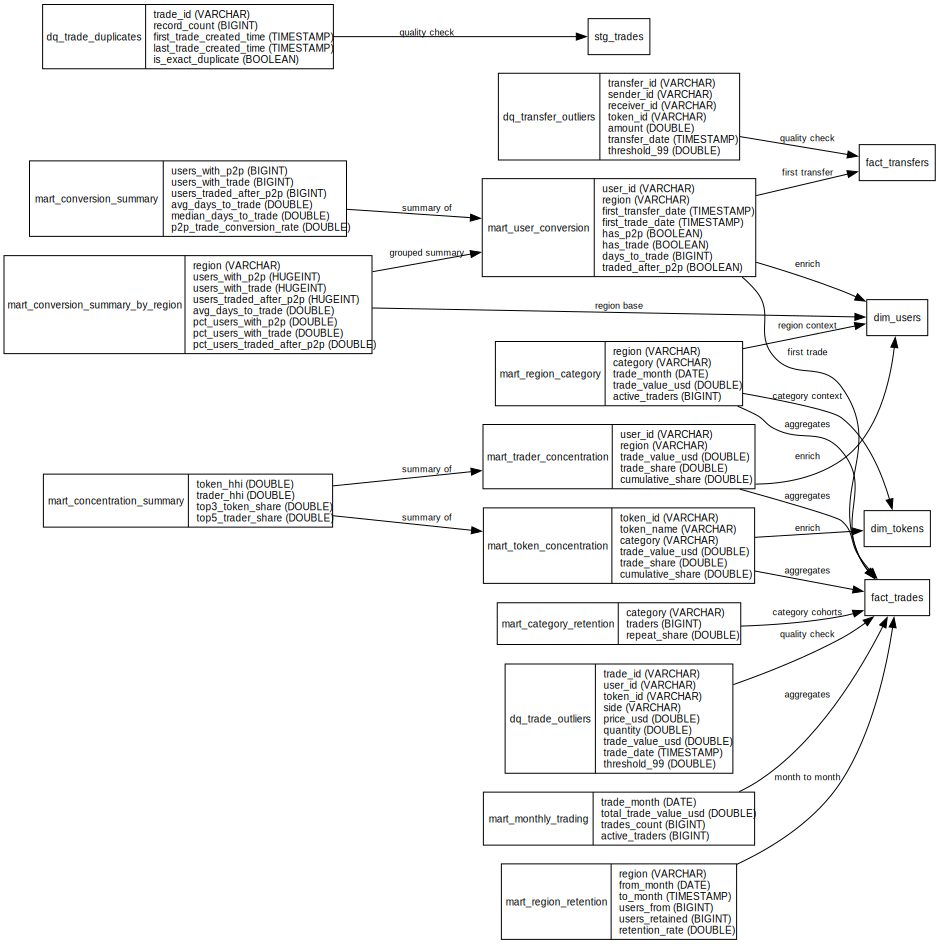

In [5]:
mart_tables = [
    "mart_token_concentration",
    "mart_trader_concentration",
    "mart_concentration_summary",
    "mart_monthly_trading",
    "mart_user_conversion",
    "mart_conversion_summary",
    "mart_conversion_summary_by_region",
    "mart_region_category",
    "mart_region_retention",
    "mart_category_retention",
    "dq_trade_duplicates",
    "dq_trade_outliers",
    "dq_transfer_outliers",
]
mart_relationships = [
    ("mart_token_concentration", "fact_trades", "aggregates"),
    ("mart_token_concentration", "dim_tokens", "enrich"),
    ("mart_trader_concentration", "fact_trades", "aggregates"),
    ("mart_trader_concentration", "dim_users", "enrich"),
    ("mart_concentration_summary", "mart_token_concentration", "summary of"),
    ("mart_concentration_summary", "mart_trader_concentration", "summary of"),
    ("mart_monthly_trading", "fact_trades", "aggregates"),
    ("mart_user_conversion", "fact_transfers", "first transfer"),
    ("mart_user_conversion", "fact_trades", "first trade"),
    ("mart_user_conversion", "dim_users", "enrich"),
    ("mart_conversion_summary", "mart_user_conversion", "summary of"),
    ("mart_conversion_summary_by_region", "mart_user_conversion", "grouped summary"),
    ("mart_conversion_summary_by_region", "dim_users", "region base"),
    ("mart_region_category", "fact_trades", "aggregates"),
    ("mart_region_category", "dim_users", "region context"),
    ("mart_region_category", "dim_tokens", "category context"),
    ("mart_region_retention", "fact_trades", "month to month"),
    ("mart_category_retention", "fact_trades", "category cohorts"),
    ("dq_trade_duplicates", "stg_trades", "quality check"),
    ("dq_trade_outliers", "fact_trades", "quality check"),
    ("dq_transfer_outliers", "fact_transfers", "quality check"),
]
render_er(
    "mart_layer",
    mart_tables,
    mart_relationships,
    filename="notebook/dev/exports/mart_layer",
)

> Run each section after populating the upstream tables to generate fresh diagrams. The SVG files are written to `notebook/dev/exports/` for easy sharing.


## Data Model Definitions

### Staging Layer

- **stg_trades**: Raw trade events including prices, quantities, and timestamps; deduplicated on `trade_id` with latest `trade_updated_time`.
- **stg_transfers**: Raw P2P transfer records with sender/receiver, token, amount, and timestamps loaded as TIMESTAMP.
- **stg_tokens**: Token reference data with `token_id`, human-readable name, and category.
- **stg_users**: User directory with region and signup date metadata.

### Dimensional Layer

- **dim_users**: Distinct user attributes used to enrich facts (user_id, region, signup_date).
- **dim_tokens**: Token lookup including category for segmentation.
- **dim_datetime**: Calendar dimension at day grain derived from trade timestamps for time-based analysis.

### Fact Layer

- **fact_trades**: Filled-order trades with calculated `trade_value_usd`, providing the core transactional fact table.
- **fact_transfers**: Successful P2P transfers with normalized dates for conversion and cross-product analysis.

### Mart Layer

- **mart_token_concentration / mart_trader_concentration**: Aggregate share-of-volume metrics by token and trader, supporting concentration risk monitoring.
- **mart_concentration_summary**: HHI and top-n share rollups derived from concentration marts.
- **mart_monthly_trading**: Monthly notional volume, trade counts, and active trader counts.
- **mart_user_conversion**: First transfer/trade timestamps and lag per user, enabling P2P-to-trade conversion tracking.
- **mart_conversion_summary / mart_conversion_summary_by_region**: Conversion KPIs overall and segmented by region populations.
- **mart_region_category**: Monthly trade value and active trader counts split by region and token category.
- **mart_region_retention**: Month-over-month retention metrics per region.
- **mart_category_retention**: Repeat usage share by token category.

### Data Quality Tables

- **dq_trade_duplicates**: Duplicate `trade_id` detections from raw trades feed.
- **dq_trade_outliers**: Trades above the 99th percentile threshold for compliance review.
- **dq_transfer_outliers**: Transfers above the 99.5th percentile threshold for AML monitoring.


In [7]:
con.close()